Found 2004 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
(20, 150, 150, 3)
(20,)
[0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]


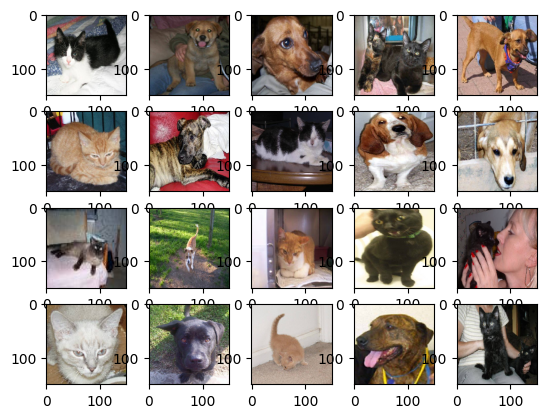

In [5]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 

#이미지 디렉토리 위치 저장
train_dir='../cat_dog_small/train'
validation_dir='../cat_dog_small/validation'

#데이터 생성 
train_datagen = ImageDataGenerator(rescale=1/255) #0~1까지 정규화 
validation_datagen = ImageDataGenerator(rescale=1/255) 

#설정 
train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats','dogs'], #클래스 지정: 타겟, 레이블
    target_size=(150,150),  
    batch_size = 20, #한번에 몇개 사이즈를 갖고 올 것인가 
    class_mode = 'binary', #0 아니면 1 개아니면 고양이를 구별하는 거라 
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats','dogs'], #클래스 지정: 타겟, 레이블
    target_size=(150,150),  
    batch_size = 20, #한번에 몇개 사이즈를 갖고 올 것인가 
    class_mode = 'binary', #0 아니면 1 개아니면 고양이를 구별하는 거라 
)

#한번에 20개 이미지 가져와서 

fig = plt.figure()
axs = []
for i in range(20):
    axs.append(fig.add_subplot(4,5,i+1))

for data_batch,label_batch in train_generator: 
    print(data_batch.shape)   
    print(label_batch.shape)
    print(label_batch) 

    for idx, img_data in enumerate(data_batch):
        axs[idx].imshow(img_data)
    
    break


In [6]:
from tensorflow.keras.applications import VGG16

model_base = VGG16(
    weights ='imagenet',
    include_top =False, #false: 필터만 가져옴. 인클루드시킬 필터를 무엇을 갖다 쓸것인지
    input_shape = (150,150,3)
    
)

model_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [7]:
#VGG16->> 전이학습 
import numpy as numpy
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.applications import VGG16

#1.모델 생성
model = Sequential()

#2. VGG16으로 대체 
model_base = VGG16(
    weights ='imagenet',
    include_top =False, #false: 필터만 가져옴. 인클루드시킬 필터를 무엇을 갖다 쓸것인지
    input_shape = (150,150,3)
)

#3.특성 추출
model_base.trainable = False #이미 완성된 필터만 사용, 변경하지 않을 것 
model.add(model_base)


model.add(Flatten())
model.add(Dense(
    units = 1,
    activation='sigmoid'
))

model.summary()

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['acc']
)

model.fit(
    train_generator,
    steps_per_epoch = 100, #2000장 이미지/20(batch size)
    epochs=30,
    validation_data = validation_generator,
    validation_steps=50, #1000/20 = 50 
    verbose=1
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 8193      
                                                                 
Total params: 14722881 (56.16 MB)
Trainable params: 8193 (32.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/30


100/100 [==============================] - 125s 1s/step - loss: 0.6146 - acc: 0.6915 - val_loss: 0.5245 - val_acc: 0.7820
Epoch 2/30
100/100 [==============================] - 122s 1s/step - loss: 0.4592 - acc: 0.8322 - val_loss: 0.4365 - val_acc: 0.8390
Epoch 